# PSF Generation Validation Template

### Parameters

In [1]:
# Debug
# psf_args = '{"pz": 0}'

In [2]:
# Parameters
psf_args = None

In [3]:
# Parameters
psf_args = "{\"pz\": 0.0, \"wavelength\": 0.45, \"min_wavelength\": 0.35}"


In [4]:
# Parse parameters
import json
psf_args = json.loads(psf_args)
psf_args

{'pz': 0.0, 'wavelength': 0.45, 'min_wavelength': 0.35}

### Initialize

In [5]:
%run utils.py
import os
import os.path as osp
import shutil
import tempfile
import numpy as np
import scipy
import pandas as pd
import papermill as pm
from skimage.measure import compare_ssim, compare_psnr
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
from scipy.stats import describe
from skimage import io
from flowdec import psf as fd_psf
import papermill as pm

PSFGEN_JAR_PATH = osp.join(osp.expanduser('~/apps/psfgenerator'), 'PSFGenerator.jar')

In [6]:
psf = fd_psf.GibsonLanni(**psf_args)
psf.config

OrderedDict([('size_x', 256),
             ('size_y', 256),
             ('size_z', 128),
             ('na', 1.4),
             ('wavelength', 0.45),
             ('m', 100),
             ('ns', 1.33),
             ('ng0', 1.5),
             ('ng', None),
             ('ni0', 1.5),
             ('ni', None),
             ('ti0', 150),
             ('tg0', 170),
             ('tg', None),
             ('res_lateral', 0.1),
             ('res_axial', 0.25),
             ('pz', 0.0),
             ('num_basis', 100),
             ('num_samples', 1000),
             ('oversampling', 2),
             ('min_wavelength', 0.35)])

### Compute PSFs

In [7]:
def run_psfgenerator(config, mode, jar_path, delete_working_dir=True, dtype='64-bits'):
    working_dir = tempfile.mkdtemp()
    print('Using working directory:', working_dir)
    cwd = os.getcwd()
    try:
        os.chdir(working_dir)
        
        # Convert the configuration for the given Flowdec PSF to a PSFGenerator config
        psfg_config = flowdec_config_to_psfgenerator_config(config, mode=mode, dtype=dtype)
        config_string = psfgenerator_config_to_string(psfg_config)
        
        # Write the config to a file
        config_path = osp.join(working_dir, 'config.txt')
        with open(config_path, 'w') as fd:
            fd.write(config_string)

        # Run PSFGenerator and read the output from it
        !java -cp $jar_path PSFGenerator config.txt
        output_path = osp.join(working_dir, 'PSF {}.tif'.format(mode))
        res = io.imread(output_path)
        
        # Delete the working directory if requested
        if delete_working_dir:
            shutil.rmtree(working_dir)
            
        return res, psfg_config, working_dir
    finally:
        os.chdir(cwd)


In [8]:
pg_res, pg_conf, pg_dir = run_psfgenerator(psf.config, 'GL', PSFGEN_JAR_PATH)

Using working directory: /var/folders/vc/j01b02990c7g90mw6v_dqpsw0000gn/T/tmpncotc2sr


Computing GL


Save PSF GL


In [9]:
pg_conf

{'PSF-shortname': 'GL',
 'ResLateral': 100.0,
 'ResAxial': 250.0,
 'NY': 256,
 'NX': 256,
 'NZ': 128,
 'Type': '64-bits',
 'NA': 1.4,
 'LUT': 'Fire',
 'Lambda': 450.0,
 'Scale': 'Linear',
 'psf-BW-NI': '1.5',
 'psf-BW-accuracy': 'Good',
 'psf-RW-NI': '1.5',
 'psf-RW-accuracy': 'Good',
 'psf-GL-NI': 1.5,
 'psf-GL-NS': 1.33,
 'psf-GL-accuracy': 'Best',
 'psf-GL-ZPos': 0.0,
 'psf-GL-TI': 150,
 'psf-TV-NI': '1.5',
 'psf-TV-ZPos': '2000.0',
 'psf-TV-TI': '150.0',
 'psf-TV-NS': '1.0',
 'psf-Circular-Pupil-defocus': '100.0',
 'psf-Circular-Pupil-axial': 'Linear',
 'psf-Circular-Pupil-focus': '0.0',
 'psf-Oriented-Gaussian-axial': 'Linear',
 'psf-Oriented-Gaussian-focus': '0.0',
 'psf-Oriented-Gaussian-defocus': '100.0',
 'psf-Astigmatism-focus': '0.0',
 'psf-Astigmatism-axial': 'Linear',
 'psf-Astigmatism-defocus': '100.0',
 'psf-Defocus-DBot': '30.0',
 'psf-Defocus-ZI': '2000.0',
 'psf-Defocus-DTop': '30.0',
 'psf-Defocus-DMid': '1.0',
 'psf-Defocus-K': '275.0',
 'psf-Cardinale-Sine-axial': 

In [10]:
pg_res.shape, pg_res.dtype

((128, 256, 256), dtype('float32'))

In [11]:
fd_res = psf.generate().astype(np.float32)

In [12]:
fd_res.shape, fd_res.dtype

((128, 256, 256), dtype('float32'))

In [13]:
describe(fd_res.ravel()), describe(pg_res.ravel())

(DescribeResult(nobs=8388608, minmax=(9.857429e-10, 1.0), mean=8.929717e-05, variance=1.3148831e-06, skewness=658.2118530273438, kurtosis=555426.1301896647),
 DescribeResult(nobs=8388608, minmax=(9.854889e-10, 1.0), mean=8.940934e-05, variance=1.3148663e-06, skewness=658.2242431640625, kurtosis=555440.2138351282))

### Visualize

In [14]:
def compare_orthogonal_views(img_fd, img_pg, pct=None, figsize=(16, 16), log=True):
    fig, ax = plt.subplots(3, 2)
    fig.set_size_inches(figsize)
    
    sh = img_fd.shape
    crop_slice = [slice(None)] * 3
    if pct:
        m = np.array(sh) // 2
        md = np.array(sh) // (1/pct)
        crop_slice = [slice(int(m[i] - md[i]), int(m[i] + md[i])) for i in range(len(m))]
        
    ax_map = ['Z', 'Y', 'X']
    for i in range(3):
        im1, im2 = img_fd.max(axis=i), img_pg.max(axis=i)
        if log:
            im1, im2 = np.log(im1), np.log(im2)
        ax[i][0].imshow(im1[[cs for j, cs in enumerate(crop_slice) if j != i]])
        ax[i][0].set_title('Max {} Projection (Flowdec)'.format(ax_map[i]))
        ax[i][1].imshow(im2[[cs for j, cs in enumerate(crop_slice) if j != i]])
        ax[i][1].set_title('Max {} Projection (PSFGenerator)'.format(ax_map[i]))

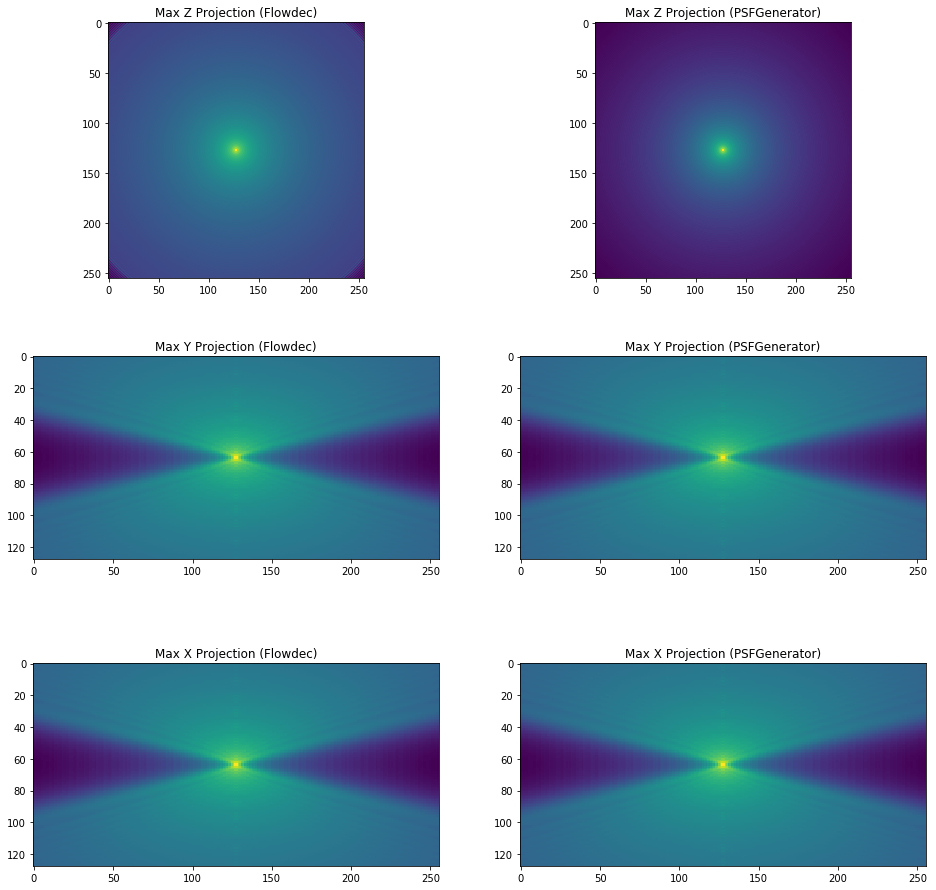

In [15]:
# Full PSF orthognal views (no zoom)
compare_orthogonal_views(fd_res, pg_res, None)

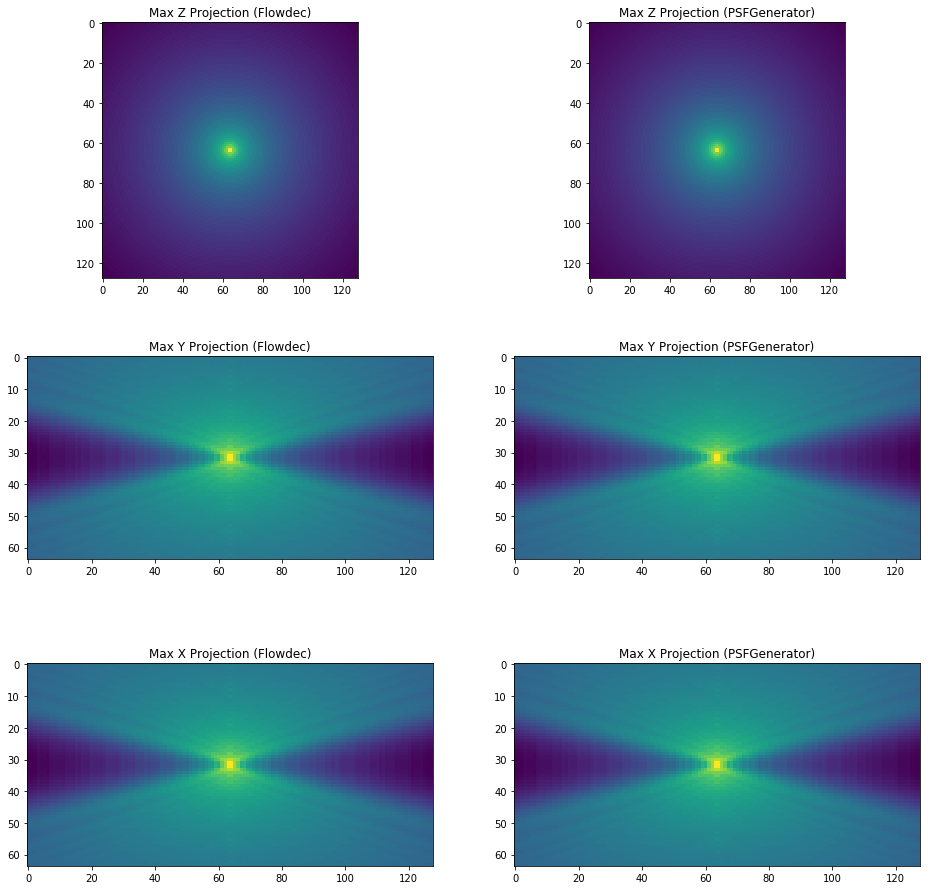

In [16]:
# PSF orthognal views at 50% zoom
compare_orthogonal_views(fd_res, pg_res, .25, log=True)

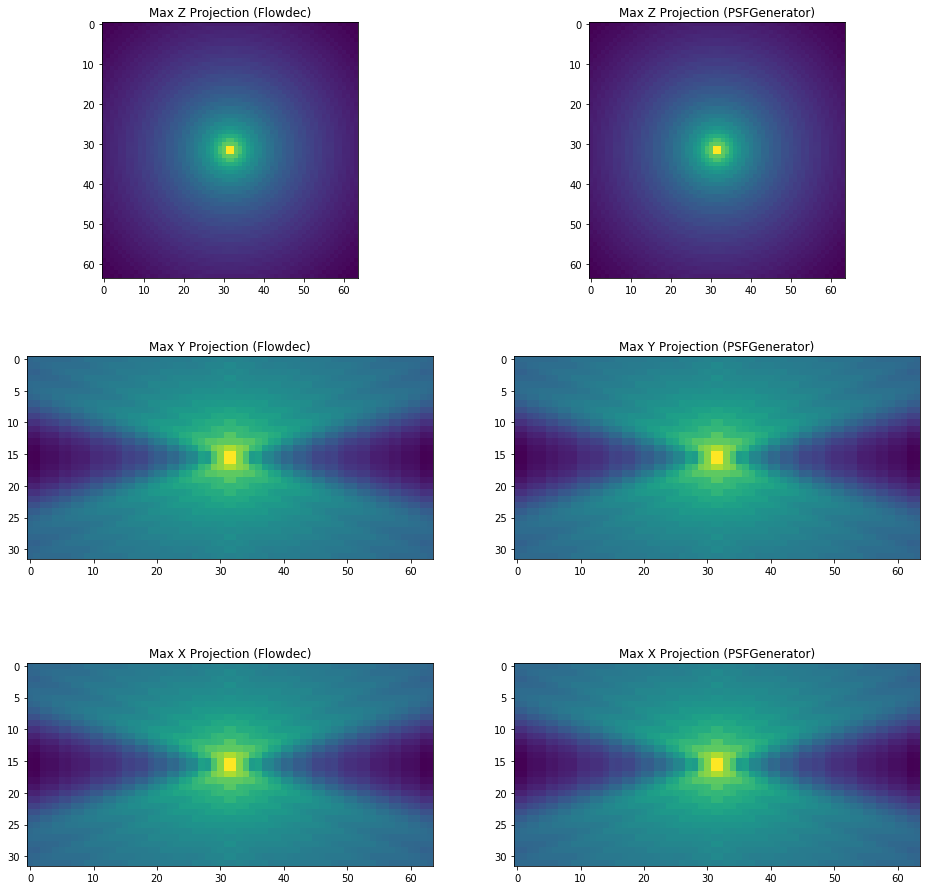

In [17]:
# PSF orthognal views at 25% zoom
compare_orthogonal_views(fd_res, pg_res, .125, log=True)

### Quantify

In [18]:
def get_summary_df(fd_res, pg_res):
    return pd.concat([
        pd.Series(fd_res.ravel()).describe().rename('Flowdec'),
        pd.Series(fd_res.ravel()).describe().rename('PSFGenerator'),
        pd.Series((fd_res - pg_res).ravel()).describe().rename('Diff')
    ], axis=1)
    
df_orig = get_summary_df(fd_res, pg_res)
df_log = get_summary_df(np.log(fd_res), np.log(pg_res))

pm.record('df_original', df_orig.to_dict())
pm.record('df_log', df_log.to_dict())

In [19]:
df_orig

,Flowdec,PSFGenerator,Diff
count,8.388608e+06,8.388608e+06,8.388608e+06
mean,8.929717e-05,8.929717e-05,-1.120979e-07
std,1.146683e-03,1.146683e-03,1.553103e-06
min,9.857429e-10,9.857429e-10,-4.638507e-05
25%,2.973783e-06,2.973783e-06,-7.486233e-08
50%,4.454563e-05,4.454563e-05,1.682565e-11
75%,8.821140e-05,8.821140e-05,6.028131e-08
max,1.000000e+00,1.000000e+00,2.753772e-05


In [20]:
df_log

,Flowdec,PSFGenerator,Diff
count,8.388608e+06,8.388608e+06,8.388608e+06
mean,-1.094432e+01,-1.094432e+01,-1.250626e-02
std,2.360600e+00,2.360600e+00,1.847311e-01
min,-2.073763e+01,-2.073763e+01,-6.280297e+00
25%,-1.272568e+01,-1.272568e+01,-1.673698e-03
50%,-1.001900e+01,-1.001900e+01,2.098083e-05
75%,-9.335774e+00,-9.335774e+00,1.663208e-03
max,0.000000e+00,0.000000e+00,5.591507e-01


In [21]:
measures = {
    'ssim_original': compare_ssim(fd_res, pg_res),
    'psnr_original': compare_psnr(fd_res, pg_res),
    'ssim_log': compare_ssim(
        rescale_intensity(np.log(fd_res), out_range=(0, 1)), 
        rescale_intensity(np.log(pg_res), out_range=(0, 1))
    ),
    'psnr_log': compare_psnr(
        rescale_intensity(np.log(fd_res), out_range=(0, 1)), 
        rescale_intensity(np.log(pg_res), out_range=(0, 1))
    )
}

pm.record('measures', measures)

measures

{'ssim_original': 0.9999999980888582,
 'psnr_original': 116.15342799861268,
 'ssim_log': 0.9986355868240275,
 'psnr_log': 40.984099215285056}